# CDL Cohort Project 2021: Week 1

In this notebook, we will summarise our work towards simulating a Google-like quantum supremacy experiment on
a trapped-ion quantum computer.

In [1]:
import qutip as qt

from src.simulation_utils import *
from src.plotting_utils import *

from functools import reduce

## 1. Speckle Patterns

For our first task, we simulate random circuits and examine the output.
These circuits consist of layers of random single-qubit gates and layers of random two-qubit MS gates.

First, we choose the number of qubits to simulate, and the depth of our random circuit:

In [2]:
n_qubits = 4         # Number of qubits
cct_depth = 1000     # Circuit depth

We initialise all qubits in the $| 0 \rangle$ state. We represent the state $| \psi \rangle = | 000 \dots 0 \rangle$ using an MPS:

In [3]:
psi = tn.onedim.init_mps_allzero(n_qubits, 2)

We apply a random circuit by drawing on randomised single- and two- qubit gates.
Each layer is constructed as an MPO and contracted into $| \psi \rangle$:

In [4]:
for j in range(cct_depth//2):
    # Generate a random single-qubit and two-qubit gate layer.
    one_qubit_layer = random_single_qubit_gate_layer(n_qubits)
    two_qubit_layer = random_two_qubit_gate_ladder(n_qubits)[np.mod(j, 2)]

    # Apply the single-qubit gate layer.
    psi = tn.onedim.contract_mps_mpo(psi, one_qubit_layer)
    psi.left_canonise(chi=None)

    # Apply the two-qubit gate layer.
    psi = tn.onedim.contract_mps_mpo(psi, two_qubit_layer)
    psi.left_canonise(chi=None)

Finally, we calculate the probabilities of measuring each output $x$ nd plot the speckle pattern of our random circuit:

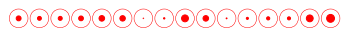

In [5]:
probs = output_probabilities(psi)
speckle_pattern(probs)

## 2. Distribution Functions

For our next task, we will look at the cumulative distribution functions of the outputs of random circuits.

We will increase the number of qubits, but reduce the circuit depth to minimise computational time.

In [6]:
n_qubits = 8       # Number of qubits
cct_depth = 500    # Circuit depth

psi = tn.onedim.init_mps_allzero(n_qubits, 2)

We perform the same simulation. However, at regular intervals we will calculate and save the speckle pattern.

In [7]:
cycles = [0, 100, 200]

speckles, depths = [], []
for j in range(cct_depth//2):
    # Random single-qubit and two-qubit gate layer.
    one_qubit_layer = random_single_qubit_gate_layer(n_qubits)
    two_qubit_layer = random_two_qubit_gate_ladder(n_qubits)[np.mod(j, 2)]

    # Apply single-qubit gate layer.
    psi = tn.onedim.contract_mps_mpo(psi, one_qubit_layer)
    psi.left_canonise(chi=None)

    # Apply two-qubit gate layer.
    psi = tn.onedim.contract_mps_mpo(psi, two_qubit_layer)
    psi.left_canonise(chi=None)

    if j in cycles:
        speckles.append(output_probabilities(psi))
        depths.append(j*2)

Using the saved speckle patterns, we can calculate the CDFs of our random circuit, and see that, for sufficient depths,
it agrees with theory:

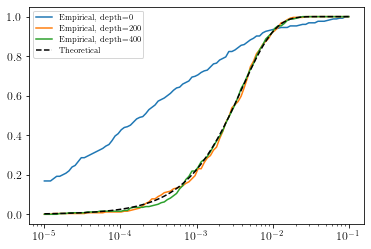

In [8]:
p = np.logspace(-5, -1, 100)

fig, ax = plt.subplots()
for s, d in zip(speckles, depths):
    ax.semilogx(
        p, cumulative(s, p), label="Empirical, depth={}".format(d)
    )

porter_thomas = 1 - np.exp(-(2 ** n_qubits) * p)
ax.semilogx(p, porter_thomas, 'k--', label="Theoretical")
ax.legend();

## 3. Adding Noise

Finally, we look at the effects of noise. We examine the effect of crosstalk and depolarising noise:

We use qutip to simulate the effects of non-unitary noise (depolarising).

In [9]:
n_sites = 4
X = qt.sigmax()
I = qt.qeye(2)
XX = qt.tensor(X, X)
H = sum([local_operator(i, XX, n_sites) for i in range(n_sites-1)])
zero = qt.operator_to_vector(qt.ket2dm(reduce(qt.tensor, [qt.basis(2,0)] * n_sites)))
# one = reduce(qt.tensor, [qt.basis(2,1)] * n_sites)

# Ising-like background noise
background = 1e-4
crosstalk_ham = sum([background * np.random.randn() * local_operator(i, XX, n_sites) for i in range(n_sites-1)])

# some bigger systematic nonlocal couplings
systematic = 1e-2
# crosstalk_ham += systematic * np.random.randn() * reduce(qt.tensor, [I,X,I,I,X,I])#,I])
crosstalk_ham += systematic * np.random.randn() * reduce(qt.tensor, [X,I,X,I])#,X,I])#,I])
crosstalk_ham += systematic * np.random.randn() * reduce(qt.tensor, [X,I,I,X])#,I,X])#,X])

crosstalk = qt.to_super(qt.propagator(crosstalk_ham, 3*np.pi/2))

In [10]:
dep = (.99) * np.eye(4 ** n_sites, 4 ** n_sites)
dep[0,0] = 1
dep_super = ptm_to_super(dep)
depolarising = qt.Qobj(dep_super, dims=crosstalk.dims, type=super)

In [19]:
slice_separation = 400

In [20]:
cct_depth = 400

speckles = []
depths = []

noise = crosstalk
psi = zero

for j in range(cct_depth):
    one_qubit_layer1 = random_single_qubit_layer_qutip(n_sites)
    one_qubit_layer2 = random_single_qubit_layer_qutip(n_sites)
    two_qubit_layer1, two_qubit_layer2 = random_two_qubit_gate_ladder_qutip(n_sites)
    psi = two_qubit_layer2 * noise * one_qubit_layer2 * noise * two_qubit_layer1 * noise *  one_qubit_layer1 * noise * psi

    if 4*j % slice_separation == 0:
        depths.append(4*j)
        prob_vec = abs(np.diag(qt.vector_to_operator(psi).full())) ** 2
        speckles.append(prob_vec)

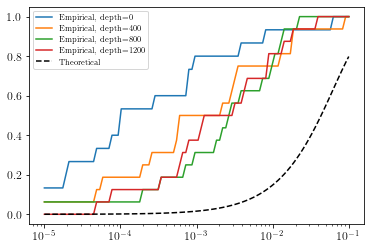

In [21]:
p = np.logspace(-5, -1, 100)

fig, ax = plt.subplots()
for s, d in zip(speckles, depths):
    ax.semilogx(
        p, cumulative(s, p), label="Empirical, depth={}".format(d)
    )

porter_thomas = 1 - np.exp(-(2 ** n_sites) * p)
ax.semilogx(p, porter_thomas, 'k--', label="Theoretical")
ax.legend();